# Build nanoparticles

SE provides a module, [`ase.cluster`](https://wiki.fysik.dtu.dk/ase/ase/cluster/cluster.html#module-ase.cluster), to set up metal nanoparticles with common crystal forms.

## Build and optimise nanoparticle

This calculation follows the [manual](https://wiki.fysik.dtu.dk/ase/gettingstarted/cluster/cluster.html)

Consider `ase.cluster.Octahedron()`. Aside from generating strictly octahedral nanoparticles, it also offers a cutoff keyword to cut the corners of the octahedron. This produces “truncated octahedra”, a well-known structural motif in nanoparticles. Also, the lattice will be consistent with the bulk FCC structure of silver.

Let set up a cuboctahedral silver nanoparticle with 55 atoms, and visualize it

In [28]:
from ase.cluster import Octahedron
from ase.visualize import view

atoms = Octahedron('Ag', 5, cutoff=2)
view(atoms, )  # viewer='ngl'

<Popen: returncode: None args: ['/home/tha/app/miniconda3/envs/py310gpaw/bin...>

Or can visualize traj with nglview

In [30]:
import nglview as nv

nv.show_ase(atoms, gui=True)

NGLWidget()

ASE provides a forcefield code based on effective medium theory, ase.calculators.emt.EMT, which works for the FCC metals (Cu, Ag, Au, Pt, and friends). This is much faster than DFT so let’s use it to optimise our cuboctahedron.

Let optimise the structure of our Ag55 cuboctahedron using the `ase.calculators.emt.EMT` calculator.

In [10]:
from ase.calculators.emt import EMT
from ase.optimize import BFGS

atoms = Octahedron('Ag', 5, cutoff=2)
atoms.calc = EMT()
opt = BFGS(atoms, trajectory='particles/Ag_opt.traj')
opt.run(fmax=0.01)

      Step     Time          Energy         fmax
BFGS:    0 22:49:18       20.334210        0.8010
BFGS:    1 22:49:18       20.147034        0.7510
BFGS:    2 22:49:18       19.301247        0.6789
BFGS:    3 22:49:18       19.196190        0.3755
BFGS:    4 22:49:18       19.155598        0.3529
BFGS:    5 22:49:18       18.907350        0.1279
BFGS:    6 22:49:18       18.893453        0.0563
BFGS:    7 22:49:18       18.891833        0.0534
BFGS:    8 22:49:19       18.886078        0.0498
BFGS:    9 22:49:19       18.882155        0.0377
BFGS:   10 22:49:19       18.880054        0.0223
BFGS:   11 22:49:19       18.879700        0.0165
BFGS:   12 22:49:19       18.879541        0.0135
BFGS:   13 22:49:19       18.879298        0.0115
BFGS:   14 22:49:19       18.879077        0.0092


True

In [ ]:
## Visualize traj with nglview
from ase.io import Trajectory
import nglview as nv

traj = Trajectory('particles/Ag_opt.traj')
# nv.show_asetraj(traj, gui=True)
view(traj)

## Ground state

One of the most interesting questions of metal nanoparticles is how their electronic structure and other properties depend on size. A small nanoparticle is like a molecule with just a few discrete energy levels. A large nanoparticle is like a bulk material with a continuous density of states. Let’s calculate the Kohn–Sham spectrum (and density of states) of our nanoparticle.

As usual, we set a few parameters to save time since this is not a real production calculation. We want a smaller basis set and also a PAW dataset with fewer electrons than normal. We also want to use Fermi smearing since there could be multiple electronic states near the Fermi level.

Let run a single-point calculation of the optimised Ag55 structure with GPAW.

After the calculation, dump the ground state to a file:
```
calc.write('groundstate.gpw')
```

In [1]:
from gpaw import GPAW, FermiDirac
from ase.io import read

atoms = read('particles/Ag_opt.traj')
atoms.center(vacuum=4.0)

calc = GPAW(mode='lcao', basis='sz(dzp)', txt='particles/Ag_gpaw.txt',
            occupations=FermiDirac(0.1), setups={'Ag': '11'})
atoms.calc = calc
atoms.get_potential_energy()
atoms.calc.write('particles/Ag_groundstate.gpw')

## Density of states

Once we have saved the `.gpw` file, we can write a new script which loads it and gets the DOS.

In this example, we sample the DOS using Gaussians of width 0.1 eV. You will want to mark the Fermi level in the plot.

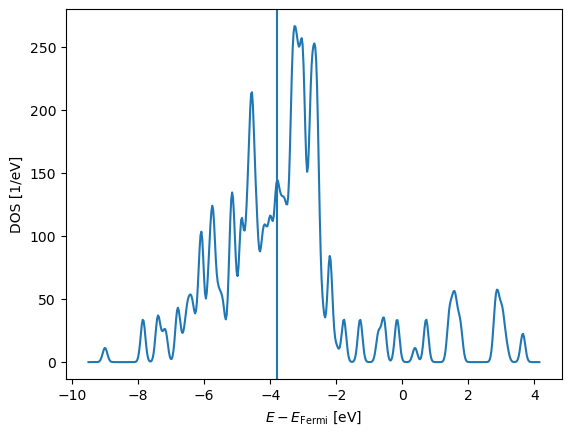

In [11]:
## DOS using ASE
import matplotlib.pyplot as plt
from gpaw import GPAW
from ase.dft.dos import DOS

calc = GPAW('particles/Ag_groundstate.gpw')
dos = DOS(calc, npts=500, width=0.1)
energies = dos.get_energies()
weights = dos.get_dos()

plt.plot(energies, weights)
plt.xlabel(r'$E - E_{\mathrm{Fermi}}$ [eV]')
plt.ylabel('DOS [1/eV]')
plt.show()

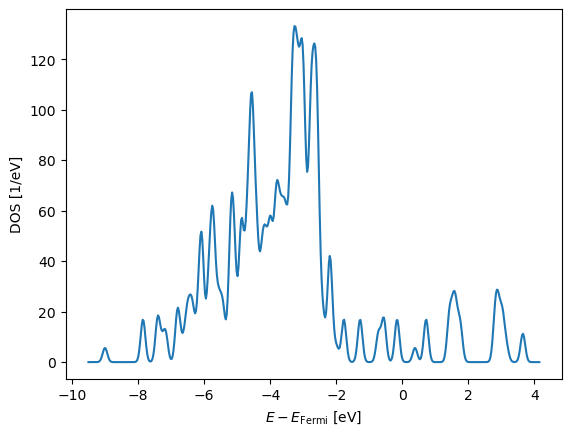

In [16]:
## DOS using GPAW
calc = GPAW('particles/Ag_groundstate.gpw')
energies, dos = calc.get_dos(npts=500, width=0.1)
efermi = calc.get_fermi_level()

plt.plot(energies - efermi, dos)
# plt.axvline(efermi)
plt.xlabel(r'$E - E_{\mathrm{Fermi}}$ [eV]')
plt.ylabel('DOS [1/eV]')
plt.show()

Why there are different in these 2 calculation? --> not yet known

Looking at the plot, is this spectrum best understood as continuous or discrete?

The graph should show us that already with 55 atoms, the plentiful d electrons are well on their way to forming a continuous band (recall we are using 0.1 eV Gaussian smearing). Meanwhile the energies of the few s electrons split over a wider range, and we clearly see isolated peaks: The s states are still clearly quantized and have significant gaps. What characterises the noble metals Cu, Ag, and Au, is that their d band is fully occupied so that the Fermi level lies among these s states. Clusters with a different number of electrons might have higher or lower Fermi level, strongly affecting their reactivity. We can conjecture that at 55 atoms, the properties of free-standing Ag nanoparticles are probably strongly size dependent.

The above analysis is speculative. To verify the analysis we would want to calculate s, p, and d-projected DOS to see if our assumptions were correct. In case we want to go on doing this, the GPAW documentation will be of help, see: GPAW DOS.